# Uniswap and Chainlink Oracle Analysis

In this notebook, I'll be briefly covering:
- how to get oracle feed prices from Chainlink, Uniswap V2, and Uniswap V3
- accuracy of ETH/USDC prices across the three sources
- historical usage of oracles, and who is using these oracles the most

Data is sourced from EDW by tokenflow insights, you can read my article on how to query this data [here](https://ath.mirror.xyz/lcZzeBcfpmfQlIHqUBmNAmv5EeVfNBGmr-S7mkWcuyo).

In [1]:
#import our packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## Oracle Prices

We're going to preprocess data from Uniswap v2/v3 first, since there isn't anything we have to change about Chainlink's data feeds. 

#### Uniswap Calculations 

For both V2 and V3, we can use the respective price accumulator values with some time-weighting to get an average price (explained in their [docs](https://docs.uniswap.org/protocol/V2/concepts/core-concepts/oracles). For V2, this means getting price1cumulative at two timestamps, then subtracting and dividing them. For V3, you need another step described [here](https://docs.uniswap.org/protocol/concepts/V3-overview/oracle#deriving-price-from-a-tick).

But essentially, in both scenarios you're looking at this: 
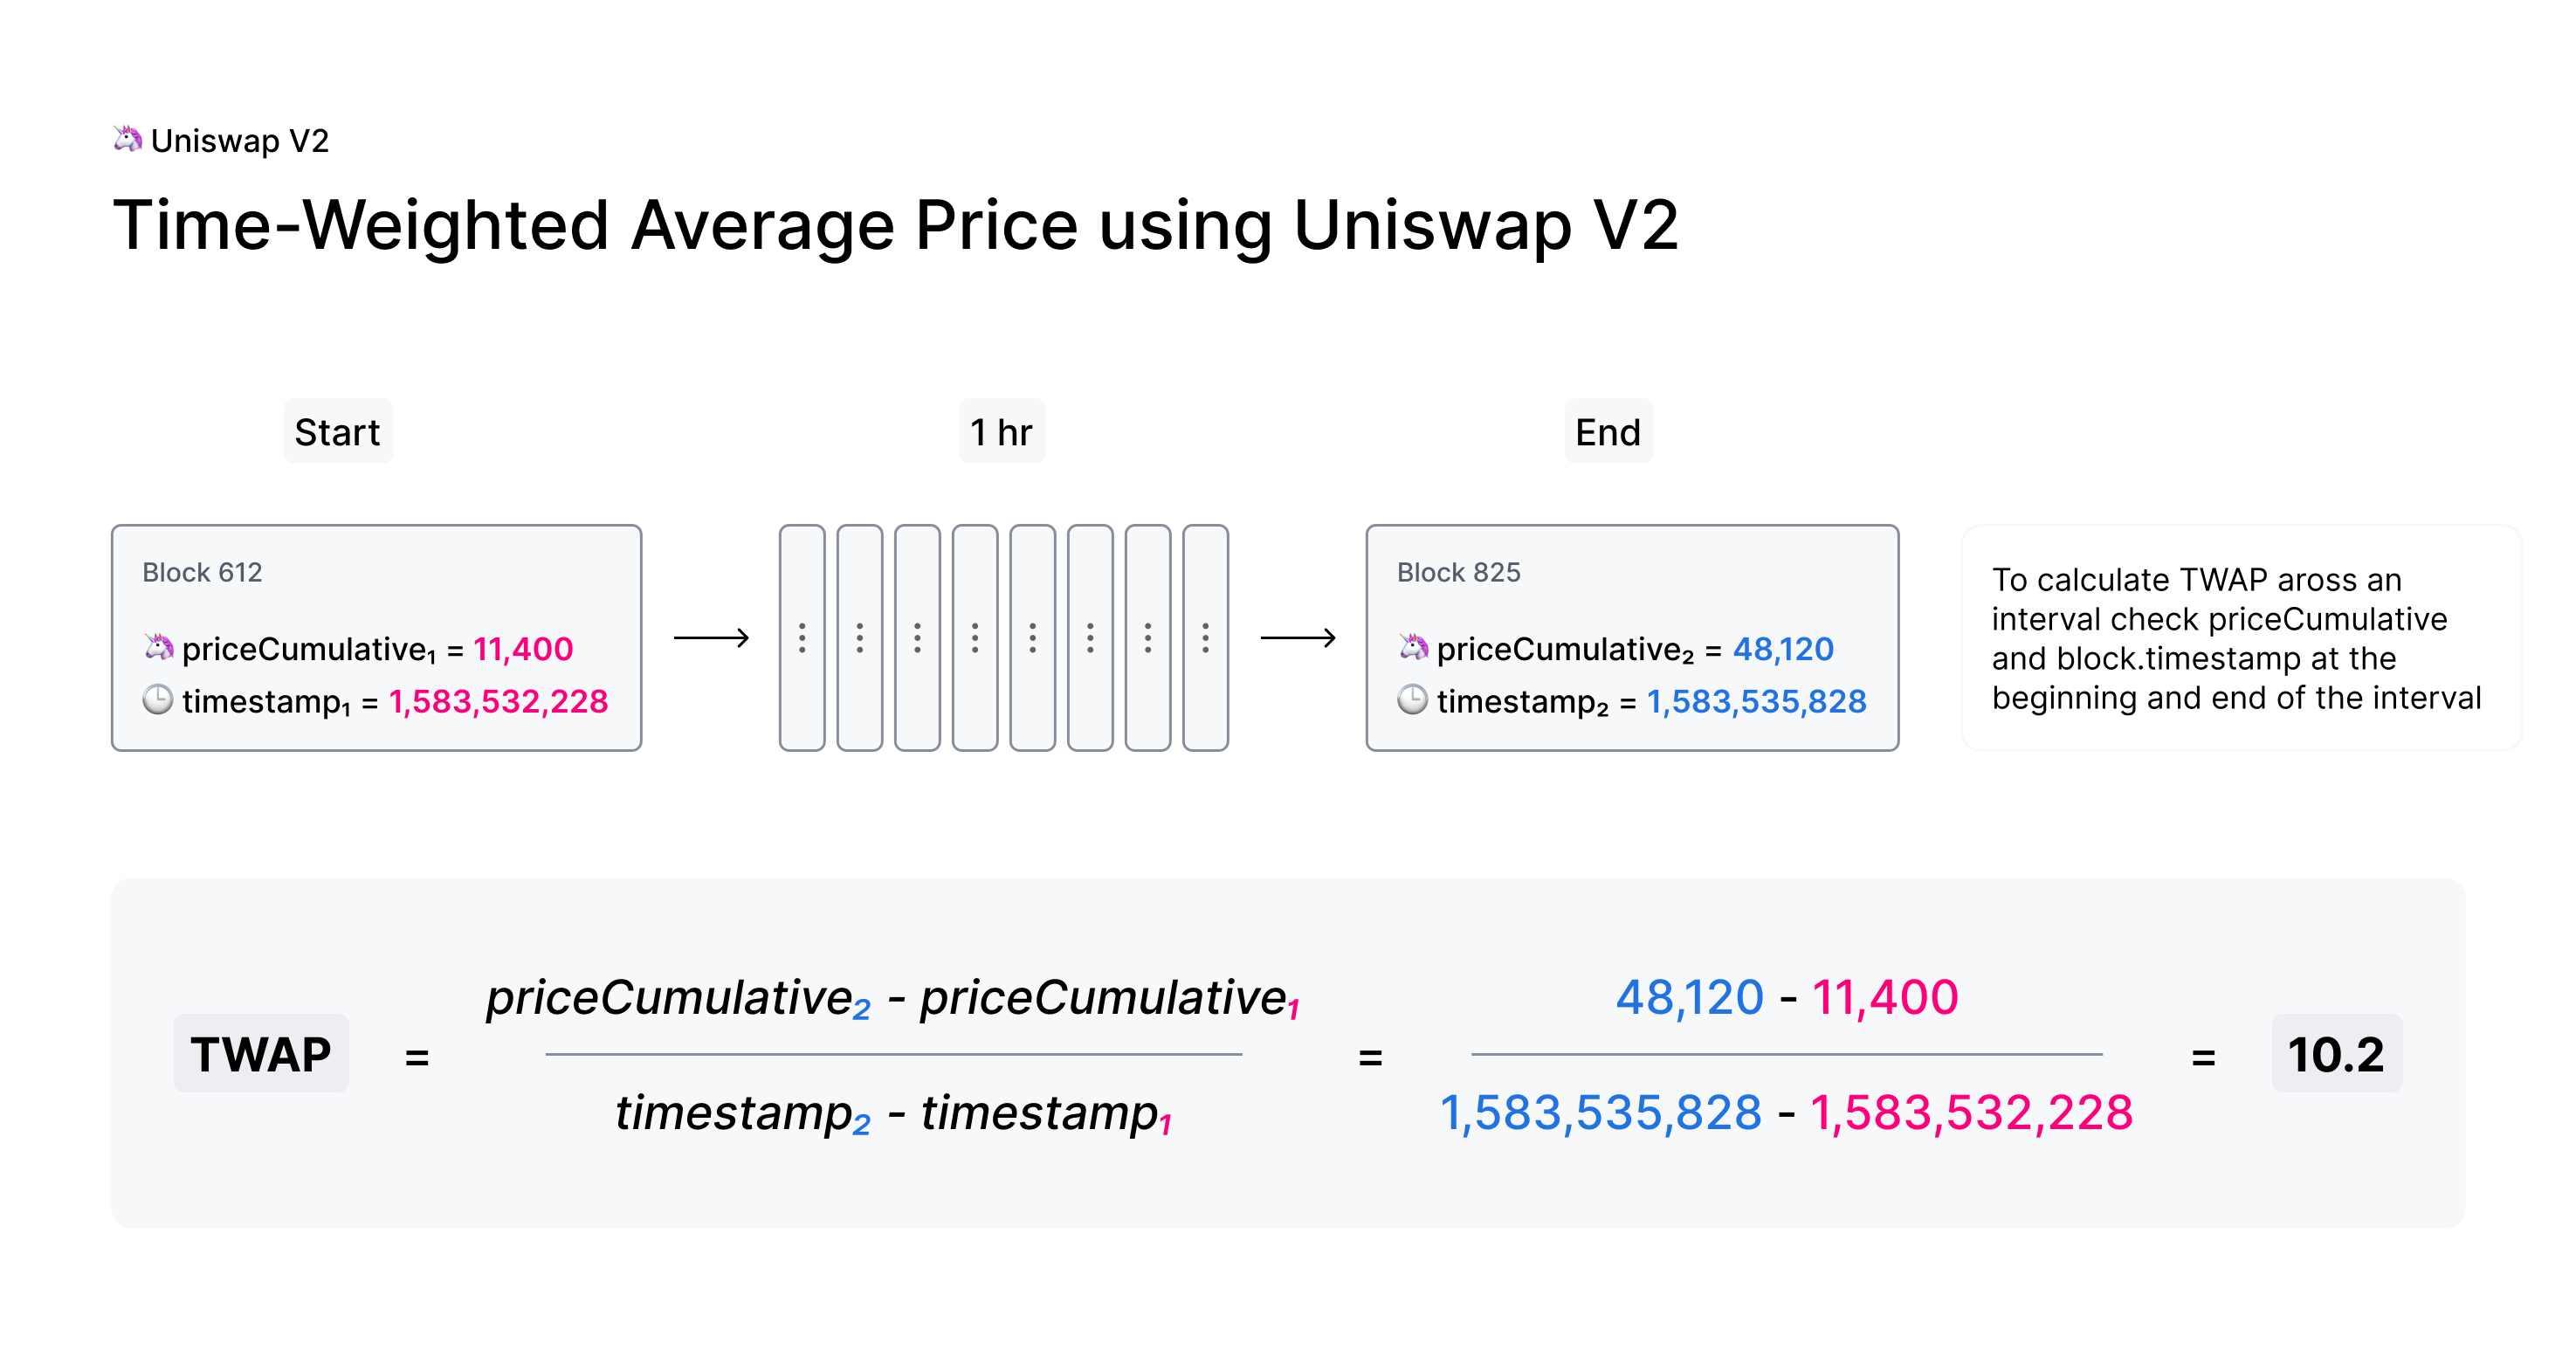

*DOCS IMPROVEMENTS: if you're from Uniswap, please add something in the docs in v2 about needing to divide prices by `2**112` due to encoding. For v3, add something about inverting the tick price calculation such that it's `(1/1.0001**i)` if it's token 1 you're calculating for instead of token 0. Thanks!*

In this notebook, you can do this just tx by tx or by setting `floor_min` to some minute value. If you don't care for different TWAP intervals, then leave it as `None`. When I was looking, setting no floor versus setting up to 10 min didn't drastically change results.

If you want to learn more about risk considerations when setting TWAP weights, check out [this great report](https://members.delphidigital.io/reports/attack-cost-and-profit-from-manipulating-constant-product-market-maker-twap-oracles-in-defi-protocols/) from Delphi. They used v2, for v3 there are likely different costs and probability curves due to discrete ticks (i.e. cheaper to manipulate if the price is near the tick edge and the next tick has low liquidity depth).

In [2]:
# used for TWAP time framing on uniswap data. Set it to <None> if you want the fastest TWAP.
min_floor = None #"5min"

In [3]:
uni_v2 = pd.read_csv(r'oracle_prices/uniswap_v2_price.csv')
uni_v2["datetime"] = pd.to_datetime(uni_v2["TIMESTAMP"])

if min_floor != None:
    uni_v2["minute_floor"] = uni_v2['datetime'].dt.floor(min_floor) #adjust this if you want to have different subsets.
    uni_v2.drop_duplicates(subset=["minute_floor"], keep='last', inplace=True) #keep only last swap results from a block/timestamp, in case of multi-swap
else:
    uni_v2.drop_duplicates(subset=["TIMESTAMP"], keep='last', inplace=True) #keep only last swap results from a block/timestamp, in case of multi-swap
uni_v2 = uni_v2.sort_values(by='datetime', ascending=True)
uni_v2.reset_index(drop=True, inplace=True)

uni_v2["price1Diff"] = uni_v2["CUMULATIVE_LAST"].diff(1) #here I'm taking the difference in prices
uni_v2["price1Diff"] = uni_v2["price1Diff"].div(2**112) #decode UQ112x112 used when storing prices in _update() function
uni_v2["timeDiffSeconds"] = uni_v2["datetime"].diff(1) #here I'm taking the difference in timestamp
uni_v2["timeDiffSeconds"] = uni_v2["timeDiffSeconds"].apply(lambda x: x.total_seconds()) #convert from interval to seconds
uni_v2["uni_v2_ETH_price"] = uni_v2["price1Diff"].div(uni_v2["timeDiffSeconds"]) #divide to get TWAP
uni_v2["uni_v2_ETH_price"] = uni_v2["uni_v2_ETH_price"].apply(lambda x: x * 1e12) #moving decimals

#some tx_hashes in EDW have wrong timestamp rn, so I filter out weird values - it's only a few of them.
uni_v2 = uni_v2[(uni_v2['uni_v2_ETH_price'] > 1000) & (uni_v2['uni_v2_ETH_price'] < 10000)] 
# uni_v2.plot(kind = "line", x = "datetime", y = "uni_v2_ETH_price")

In [4]:
uni_v2.head()

,BLOCK,TIMESTAMP,CUMULATIVE_LAST,datetime,price1Diff,timeDiffSeconds,uni_v2_ETH_price
1,12381346,2021-05-06T14:46:38Z,1.403084e+32,2021-05-06 14:46:38+00:00,0.0,22.0,3493.391407
2,12381347,2021-05-06T14:46:45Z,1.403085e+32,2021-05-06 14:46:45+00:00,0.0,7.0,3493.339610
3,12381350,2021-05-06T14:47:09Z,1.403090e+32,2021-05-06 14:47:09+00:00,0.0,24.0,3493.126122
4,12381353,2021-05-06T14:47:39Z,1.403095e+32,2021-05-06 14:47:39+00:00,0.0,30.0,3492.738210
5,12381354,2021-05-06T14:47:49Z,1.403097e+32,2021-05-06 14:47:49+00:00,0.0,10.0,3492.759138


In [5]:
#all of this is basically same as above in v2, just an extra function in the last lambda.
uni_v3_03 = pd.read_csv(r'oracle_prices/uniswapv3_storage_003_0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8.csv')
uni_v3_03.dropna(inplace=True)
uni_v3_03["datetime"] = pd.to_datetime(uni_v3_03["TIMESTAMP"])

if min_floor != None:
    uni_v3_03["minute_floor"] = uni_v3_03['datetime'].dt.floor(min_floor) #adjust this if you want to have different subsets.
    uni_v3_03.drop_duplicates(subset=["minute_floor"], keep='last', inplace=True) #keep only last swap results from a block/timestamp, in case of multi-swap
else:
    uni_v3_03.drop_duplicates(subset=["TIMESTAMP"], keep='last', inplace=True)
uni_v3_03.reset_index(drop=True, inplace=True)

uni_v3_03["tickDiff"] = uni_v3_03["TICKCUMULATIVE"].diff(1)
uni_v3_03["timeDiffSeconds"] = uni_v3_03["datetime"].diff(1)
uni_v3_03["timeDiffSeconds"] = uni_v3_03["timeDiffSeconds"].apply(lambda x: x.total_seconds())
uni_v3_03["average_tick"] = uni_v3_03["tickDiff"].div(uni_v3_03["timeDiffSeconds"])
uni_v3_03["uni_v3_ETH_price"] = uni_v3_03["average_tick"].apply(lambda x: 1/(1.0001**x) * 1e12) #inverse of exponential for token1, then move decimals

#filtering for same reason as earlier
uni_v3_03 = uni_v3_03[(uni_v3_03['average_tick'] > 100000) & (uni_v3_03['average_tick'] < 300000)]

In [6]:
uni_v3_03.head()

,TIMESTAMP,INDEX,TICKCUMULATIVE,datetime,tickDiff,timeDiffSeconds,average_tick,uni_v3_ETH_price
1,2021-05-06T14:57:38Z,1,2.793897e+10,2021-05-06 14:57:38+00:00,2336640.0,12.0,194720.00000,3498.167892
2,2021-05-06T15:01:00Z,1,2.797830e+10,2021-05-06 15:01:00+00:00,39329824.0,202.0,194702.09901,3504.435254
3,2021-05-06T15:01:10Z,1,2.798025e+10,2021-05-06 15:01:10+00:00,1947050.0,10.0,194705.00000,3503.418819
4,2021-05-06T15:03:41Z,1,2.800965e+10,2021-05-06 15:03:41+00:00,29400304.0,151.0,194704.00000,3503.769161
5,2021-05-06T15:05:22Z,1,2.802931e+10,2021-05-06 15:05:22+00:00,19665104.0,101.0,194704.00000,3503.769161


#### Chainlink Calculations 

For chainlink I just do some deduplication, that's it. They use a proxy that gets price data from aggregator contracts (ETH/USDC has switched aggregators five times, you can read how it works [here](https://docs.chain.link/docs/architecture-decentralized-model/ )).

In [7]:
chainlink = pd.read_csv(r'oracle_prices/chainlink_oracle_price.csv')
chainlink["datetime"] = pd.to_datetime(chainlink['TIMESTAMP'])
chainlink = chainlink[chainlink["ETH_PRICE"] != 0] #for some reason EDW shows some 70 values as 0, maybe a read error?
chainlink.drop_duplicates(subset='TIMESTAMP', keep='last', inplace=True)
chainlink.rename(columns={'ETH_PRICE': 'chainlink_ETH_price'}, inplace=True)

In [8]:
chainlink.head()

,TIMESTAMP,BLOCK,chainlink_ETH_price,datetime
0,2021-05-06T14:46:38Z,12381346,3490.998294,2021-05-06 14:46:38+00:00
1,2021-05-06T14:46:57Z,12381348,3490.998294,2021-05-06 14:46:57+00:00
2,2021-05-06T14:47:17Z,12381351,3490.998294,2021-05-06 14:47:17+00:00
3,2021-05-06T14:48:07Z,12381357,3490.998294,2021-05-06 14:48:07+00:00
4,2021-05-06T14:54:29Z,12381383,3509.283970,2021-05-06 14:54:29+00:00


### Comparing prices across oracles over time

Let's join all the tables, and do a forward fill for any missing timestamps after outer join.

In [9]:
notionals = ["chainlink_ETH_price", "uni_v2_ETH_price", "uni_v3_ETH_price"] 
comps = ["univ2_chainlink_diff", "univ3_chainlink_diff", "univ2_chainlink_ratio","univ3_chainlink_ratio"]

merged_data = pd.merge(uni_v2[["datetime", "uni_v2_ETH_price"]], uni_v3_03[["datetime", "uni_v3_ETH_price"]],left_on = 'datetime', right_on = 'datetime', how = 'outer')
merged_data = pd.merge(merged_data, chainlink[["datetime", "chainlink_ETH_price"]], left_on = 'datetime', right_on = 'datetime', how = 'outer')
merged_data.sort_values(by = 'datetime', ascending=True, inplace=True)
merged_data = merged_data.ffill() #chainlink ffill is a bit erroneous but good enough for now.

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

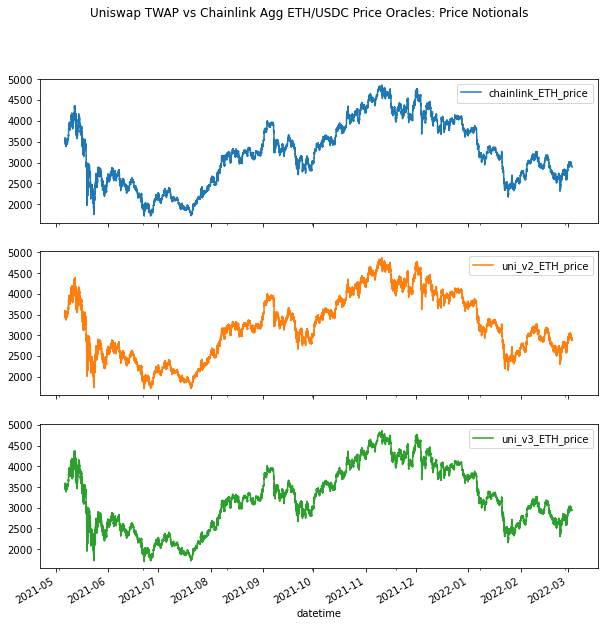

In [10]:
## line plot notionals
merged_data.plot(kind="line", 
                  x = "datetime", 
                  y = notionals,
                  title = "Uniswap TWAP vs Chainlink Agg ETH/USDC Price Oracles: Price Notionals",
                  subplots=True,
                  figsize = (10,10))

Here, we calculate the notional differences in prices between uniswap and chainlink, as well as a the ratio of prices.

In [11]:
merged_data["univ2_chainlink_diff"] = merged_data["uni_v2_ETH_price"] - merged_data["chainlink_ETH_price"]
merged_data["univ3_chainlink_diff"] = merged_data["uni_v3_ETH_price"] - merged_data["chainlink_ETH_price"]
merged_data["univ2_chainlink_ratio"] = merged_data["uni_v2_ETH_price"].div(merged_data["chainlink_ETH_price"])
merged_data["univ3_chainlink_ratio"] = merged_data["uni_v3_ETH_price"].div(merged_data["chainlink_ETH_price"])

In [12]:
#pivot table to minute just to simplify the number of rows - otherwise you're plotting way too many points. 
merged_data["minute"] = merged_data["datetime"].dt.round('1min')
minute_differences = merged_data.pivot_table(index="minute", values = comps, aggfunc = "mean")
minute_differences.reset_index(inplace=True)

array([<AxesSubplot:xlabel='minute'>, <AxesSubplot:xlabel='minute'>,
       <AxesSubplot:xlabel='minute'>, <AxesSubplot:xlabel='minute'>],
      dtype=object)

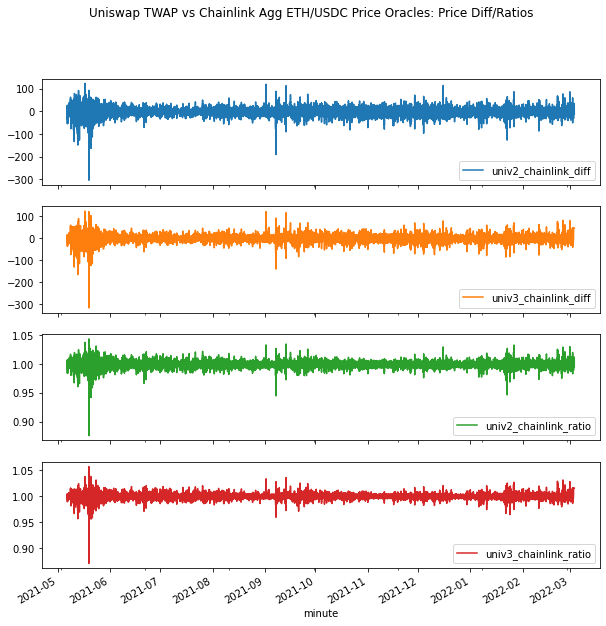

In [13]:
## line plot comps (diffs, ratios)
minute_differences.plot(kind="line", 
                  x = "minute", 
                  y = comps, 
                  subplots = True, 
                  figsize = (10,10),
                  title = "Uniswap TWAP vs Chainlink Agg ETH/USDC Price Oracles: Price Diff/Ratios")

We also want to study the density plots of both price differences and price ratios, to better understand the distribution of accuracy and spread of prices.

In [14]:
#stacked dfs for seaborn hue stuff (requires typed cloumns)
differences_df = minute_differences[["minute","univ3_chainlink_diff", "univ2_chainlink_diff"]].set_index("minute").stack()
differences_df = differences_df.reset_index()
differences_df.columns = ["minute", "price_source", "price_difference"]

ratio_df = minute_differences[["minute","univ3_chainlink_ratio", "univ2_chainlink_ratio"]].set_index("minute").stack()
ratio_df = ratio_df.reset_index()
ratio_df.columns = ["minute", "price_source", "price_ratio"]

C:\Users\13104\anaconda3\envs\dev\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


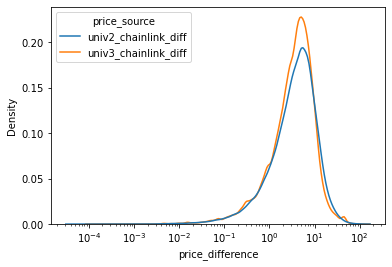

In [15]:
diff_fig = sns.kdeplot(data=differences_df, x="price_difference", hue="price_source", log_scale=True)
#don't worry about the log error.

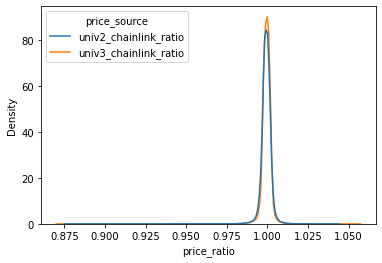

In [16]:
ratio_fig = sns.kdeplot(data=ratio_df, x="price_ratio", hue="price_source", log_scale=False)

Overall, uniswap v3 gives a tighter and better TWAP oracle price than uniswap v2. I wouldn't take this as definitive across pairs or time, and there's definitely still a lot of follow up analysis to do. If you want to take a stab at it, here are some research questions to jump off of: 
- role of arb bots, i.e. when are they most active, and how does their activity align/correlate with accuracy?
- zooming in on different phases/trends in the time series
- trading volume correlation with ratio/diffs at points in time where diffs are larger
- different token pairs (two non-stables would be fun), and comparing price ratios

## Oracle Usage Over Time

Let's check out how these oracles are being used over time, which I've defined in two variables: 
- `daily total oracle calls`: daily number of calls to the oracle contract to query prices
- `daily unique contracts (calling oracle)`: daily number of unique addresses (contracts) which are calling the oracle (accessing the storage slots for ETH/USDC price).

In [23]:
#bring in time series read data for uniswap and chainlink, and then join them
time_univ2 = pd.read_csv(r'oracle_reads/daily_reads_uniswapv2.csv')
time_univ2.columns = ["datetime", "daily total oracle calls", "daily unique contracts (calling oracle)"]
time_univ2["datetime"] = pd.to_datetime(time_univ2['datetime'])

time_univ3 = pd.read_csv(r'oracle_reads/daily_reads_uniswapv3.csv')
time_univ3.columns = ["datetime", "daily total oracle calls", "daily unique contracts (calling oracle)"]
time_univ3["datetime"] = pd.to_datetime(time_univ3['datetime'])

time_chainlink = pd.read_csv(r'oracle_reads/daily_reads_chainlink.csv')
time_chainlink.columns = ["datetime", "daily total oracle calls", "daily unique contracts (calling oracle)"]
time_chainlink["datetime"] = pd.to_datetime(time_chainlink['datetime'])

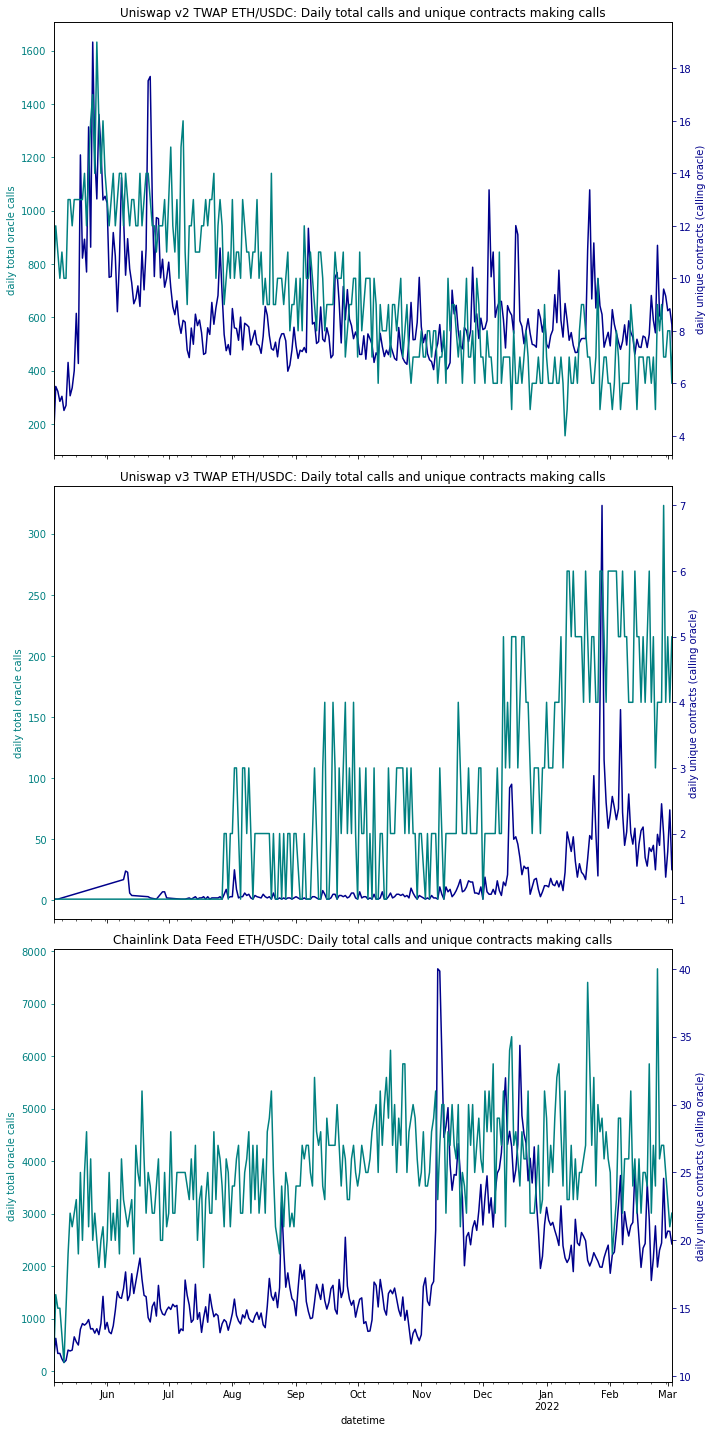

In [29]:
#plot usage/sources with subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex= True, figsize=(10,20))
ax1twin = ax1.twinx()
ax2twin = ax2.twinx()
ax3twin = ax3.twinx()

#v2 plot
time_univ2.plot(kind="line", 
                    x = "datetime", 
                    y = "daily total oracle calls",
                    color = 'teal',
                    title = "Uniswap v2 TWAP ETH/USDC: Daily total calls and unique contracts making calls",
                    legend=False,
                    ax = ax1twin)

time_univ2.plot(kind="line", 
                    x = "datetime", 
                    y = "daily unique contracts (calling oracle)",
                    color = "darkblue",
                    legend=False,
                    ax = ax1)

ax1.set(ylabel="daily total oracle calls")
ax1.tick_params(axis='y', colors='teal')
ax1.yaxis.label.set_color('teal')
ax1twin.set(ylabel="daily unique contracts (calling oracle)")
ax1twin.tick_params(axis='y', colors='darkblue')
ax1twin.yaxis.label.set_color('darkblue')

#v3 plot
time_univ3.plot(kind="line", 
                    x = "datetime", 
                    y = "daily total oracle calls",
                    color = 'teal',
                    title = "Uniswap v3 TWAP ETH/USDC: Daily total calls and unique contracts making calls",
                    legend=False,
                    ax = ax2twin)

time_univ3.plot(kind="line", 
                    x = "datetime", 
                    y = "daily unique contracts (calling oracle)",
                    color = "darkblue",
                    legend=False,
                    ax = ax2)

ax2.set(ylabel="daily total oracle calls")
ax2.tick_params(axis='y', colors='teal')
ax2.yaxis.label.set_color('teal')
ax2twin.set(ylabel="daily unique contracts (calling oracle)")
ax2twin.tick_params(axis='y', colors='darkblue')
ax2twin.yaxis.label.set_color('darkblue')

#chainlink plot
time_chainlink.plot(kind="line", 
                    x = "datetime", 
                    y = "daily total oracle calls",
                    title = "Chainlink Data Feed ETH/USDC: Daily total calls and unique contracts making calls",
                    color = 'teal',
                    legend=False,
                    ax = ax3twin)

time_chainlink.plot(kind="line", 
                    x = "datetime", 
                    y = "daily unique contracts (calling oracle)",
                    color = 'darkblue',
                    legend=False,
                    ax = ax3)

ax3.set(ylabel="daily total oracle calls")
ax3.tick_params(axis='y', colors='teal')
ax3.yaxis.label.set_color('teal')
ax3twin.set(ylabel="daily unique contracts (calling oracle)")
ax3twin.tick_params(axis='y', colors='darkblue')
ax3twin.yaxis.label.set_color('darkblue')

fig.tight_layout() 

There are a lot of data caveats here for Uniswap Oracles, because both versions are typically used in an abstracted pattern rather than direct querying. 

For Uniswap V2, the data is heavily understated due to reads being mostly for storage/benchmark purposes. There are more reads purely because prices need to be checked and stored at some interval, before being used elsewhere. The fact that there is dropoff tells me that it isn't being used as much, and likely users have migrated to V3 (since pickup in V3 seems to coincide with dropoff in V3).

For Uniswap V3, the data is fairly representative because when the abstracted oracle calculator is called the calculator called the V3 pair in the same transaction (so it doesn't act as storage). It's not as high as I expected it to be, and I'm not too sure why. Having multiple contracts per pair may be a factor, I haven't checked the 0.3% fee pair contract - this is only the 0.05% fee pair contract.

## Top Users (Other Contracts/Protocols) that rely on these price oracles

**Uniswap V2/V3 Oracles**: The top reads were actually by two other oracles, so the analysis is a little tricky. On a high level, it looks like it's a common pattern to build an oracle calculator on top of it that makes history and cross-pool prices easier to check.

**Chainlink Data Feeds**: The top user by far is ENS with 400k+ queries - which checks the ETH price during each registration. Other than that, it's used by protocols like Aave and Inverse Finance.

I haven't really dived deeper than the top 10 or 20 addresses, but it would be cool to tie this to an oracle usage guide like Linda's old repo [here](https://github.com/linda-xie/defi-oracles). 

---

**The top address that uses Chainlink's ETH/USDC price feeds** is `0x63faf46dadc9676745836289404b39136622b821`, which is a Linear Price oracle used by ENS upon various registar transactions like [this one](https://etherscan.io/tx/0xd5e1b1a297ef8d77d5b6d7beb057d9b4f4e17225dc3032afdbba981a2419850a/advanced). 

In [6]:
top_chainlink = pd.read_csv(r'oracle_reads/top_reads_chainlink.csv')

top_chainlink.head(10)

,FROM_ADDRESS,TOTAL_TIMES_QUERIED
0,0x63faf46dadc9676745836289404b39136622b821,439181
1,0xa51b83e420c5f82982dc8b7f4514c9bea0b290ee,84069
2,0xb503cd2492b871ef3d6d972777814934011bf29c,11189
3,0xec6f4cd64d28ef32507e2dc399948aae9bbedd7e,10651
4,0x210ac53b27f16e20a9aa7d16260f84693390258f,3055
5,0xe8929afd47064efd36a7fb51da3f8c5eb40c4cb4,3005
6,0xb825e25856bd98b3f2faf2aeb6cb8742b38c4025,2833
7,0x3d619bc03014917d3b27b3b86452346af36e58de,2668
8,0x82e9283e7a64ae1516ef6753dc9d733609c07491,2565
9,0x1ad386d647c216f3fe5a4fc04f6e4cb83e3048cf,2488


---

**For Uniswap V3**, the top two addresses making queries here are both Oracle calculator contracts. Other notable ones include Euler protocol (`0x27182842e098f60e3d576794a5bffb0777e025d3`) and a Keep3r contract (`0xedb67ee1b171c4ec66e6c10ec43edbba20fae8e9`)

In [17]:
top_univ3 = pd.read_csv(r'oracle_reads/top_reads_uniswapv3.csv')

top_univ3.head(10)

,FROM_ADDRESS,TOTAL_TIMES_QUERIED
0,0x65d66c76447ccb45daf1e8044e918fa786a483a1,1174
1,0x0f1f5a87f99f0918e6c81f16e59f3518698221ff,1092
2,0xedb67ee1b171c4ec66e6c10ec43edbba20fae8e9,596
3,0x27182842e098f60e3d576794a5bffb0777e025d3,567
4,0xad8a5c16fdf36e568f602d088dd0c0ade52dd652,429
5,0x00d54f129293b1580c779c8f04b2d8ce370ca69d,236
6,0xf79ad166c7ec3a8d49c0fb3903b8c26f46ff0ee0,175
7,0xe08d86fc31b497e79d321857248bee230f4c9953,74
8,0x4df938e57fd4ad1dfdddeeb1b4cfabab19e33a0e,60
9,0xf120f029ac143633d1942e48ae2dfa2036c5786c,52


The first Oracle calculator `0x65d66c76447ccb45daf1e8044e918fa786a483a1` is mostly queried by a Controller contract (`0x64187ae08781b09368e6253f9e94951243a493d5`), which I haven't been able to figure out who this belongs to yet. The main product reference in the Solidity code is something about power perpetuals (maybe it's Opyn?).

`0x0f1f5a87f99f0918e6c81f16e59f3518698221ff` is mostly queried by a staking contract `0xbe921c6e9799a0b12d8cf6bb1fcc7794e0a24f81` (961 of the 1092 queries) and two other price oracles (`0xec738877f8a0deac03cd7c2176f1275ab18a7f9c`, `0x3d619bc03014917d3b27b3b86452346af36e58de`).

It was easier to track who is calling V3 these because these two contracts are set up to just calculate TWAP, and not store any prices - as such I could just follow the internal call path of `user -> someContract -> oracle calculator -> actual pair contract`. The queries for these two Oracle calculators can be found in the `read_queries_edw-extraOraclesV3.txt` file, in case you want to explore some more.

---

**Uniswap V2 didn't store historical prices, only most recent**, so most/all of the contracts calling for prices were doing so just to store the price. These storage contracts were querying prices for many pairs and not just ETH/USDC, so it wasn't easy to decode when ETH/USDC was being queried versus another pair.

In [26]:
top_univ2 = pd.read_csv(r'oracle_reads/top_reads_uniswapv2.csv')

top_univ2.head(10)

,FROM_ADDRESS,TOTAL_TIMES_QUERIED
0,0x6d2299c48a8dd07a872fdd0f8233924872ad1071,79954
1,0x046728da7cb8272284238bd3e47909823d63a58d,64744
2,0x087f35bd241e41fc28e43f0e8c58d283dd55bd65,25566
3,0x841616a5cba946cf415efe8a326a621a794d0f97,25086
4,0x65c816077c29b557bee980ae3cc2dce80204a0c5,4588
5,0x34ab75d077c148f1ecaa435e7125c16842a0aea3,4213
6,0xc1e088fc1323b20bcbee9bd1b9fc9546db5624c5,3986
7,0xf751f24dd9cfad885984d1ba68860f558d21e52a,3235
8,0x69b9e922eca72cda644a8e32b8427000059388c6,2791
9,0x48c1a83c9496f0d6f0000b6d7f78c7b23f9e9c5a,1381


These four contracts in the top 10 are all Chainlink aggregators, old and unused now. I know this because they're all `UniswapAnchoredView` that feed into `AccessControlledOffchainAggregator` contracts [like this one](https://etherscan.io/address/0xe3f0dede4b499c07e12475087ab1a084b5f93bc0#code).
- `0x6d2299c48a8dd07a872fdd0f8233924872ad1071`
- `0x046728da7cb8272284238bd3e47909823d63a58d`
- `0x841616a5cba946cf415efe8a326a621a794d0f97`
- `0x65c816077c29b557bee980ae3cc2dce80204a0c5`

The third top queryer, `0x087f35bd241e41fc28e43f0e8c58d283dd55bd65`, is a UniswapOracle used by Fei - but hasn't been updated in over 200 days so it's not in use anymore.